In [150]:
import pandas as pd

# Load dataset with specified encoding
data = pd.read_csv('data.csv', encoding='latin-1')  

# Check missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Display total rows
total_rows = data.shape[0]
print(f"Total number of rows: {total_rows}")

# Display data types
print("Data Types:")
print(data.dtypes)


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Total number of rows: 541909
Data Types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [151]:
# Check missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [152]:
# Drop rows with missing 'CustomerID'
data = data.dropna(subset=['CustomerID'])

# Check missing values after dropping
missing_values = data.isnull().sum()
print("Missing Values after dropping rows with missing CustomerID:")
print(missing_values)



Missing Values after dropping rows with missing CustomerID:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [153]:
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate Recency
current_date = data['InvoiceDate'].max()
recency = current_date - data.groupby('CustomerID')['InvoiceDate'].max()
recency = recency.dt.days  # Extract the number of days

# Calculate Frequency
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique()

# Calculate Monetary Value
monetary = data.groupby('CustomerID').agg({'Quantity': 'sum', 'UnitPrice': 'sum'})
monetary['Monetary'] = monetary['Quantity'] * monetary['UnitPrice']

# Combine into RFM DataFrame
rfm_data = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary['Monetary']
})

print(rfm_data.head())


            Recency  Frequency    Monetary
CustomerID                                
12346.0         325          2        0.00
12347.0           1          7  1182814.18
12348.0          74          4   418360.11
12349.0          18          1   381818.10
12350.0         309          1    12864.10


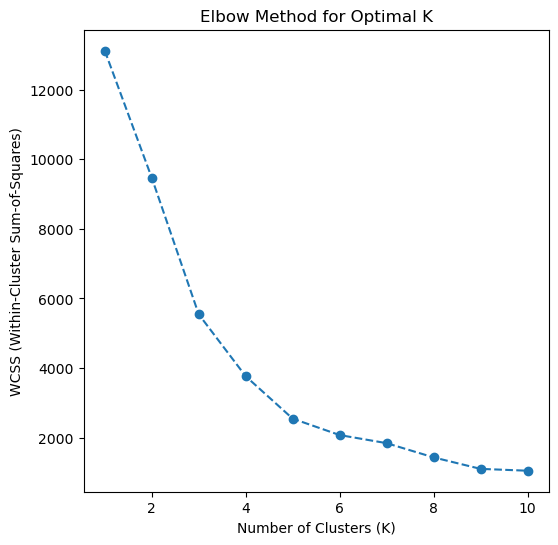

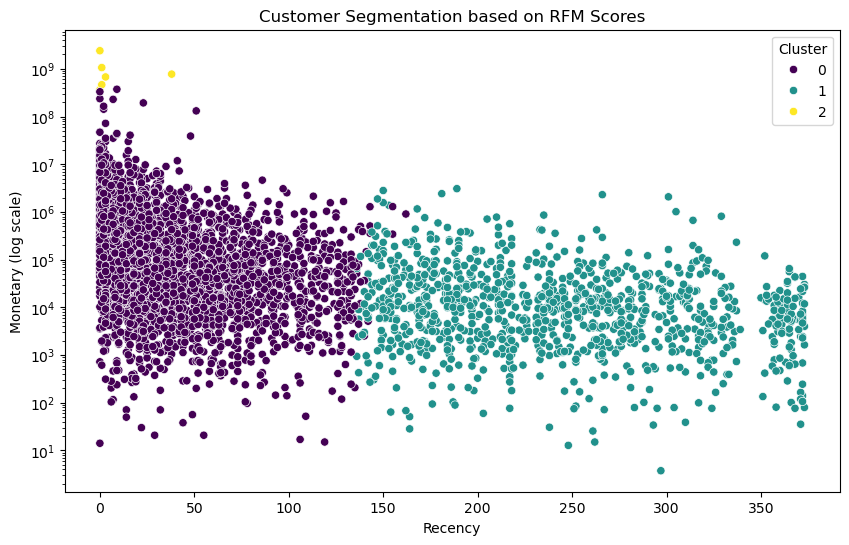

In [154]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Prepare RFM data for clustering
rfm_for_clustering = rfm_data[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

# Determine optimal clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum-of-Squares)")
plt.show()

# Clustering with optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_data, palette='viridis', legend='full')
plt.yscale('log')
plt.title("Customer Segmentation based on RFM Scores")
plt.xlabel("Recency")
plt.ylabel("Monetary (log scale)")
plt.show()


In [155]:
# Segment profiling
segment_profiles = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

segment_profiles['Number of Customers'] = rfm_data['Cluster'].value_counts().sort_index().values

segment_profiles = segment_profiles.rename(columns={
    'Recency': 'Average Recency',
    'Frequency': 'Average Frequency',
    'Monetary': 'Average Monetary'
})

print(segment_profiles)


   Cluster  Average Recency  Average Frequency  Average Monetary  \
0        0        38.815838           5.927563      1.396348e+06   
1        1       245.083935           1.850181      5.193095e+04   
2        2         7.166667         138.000000      9.569100e+08   

   Number of Customers  
0                 3258  
1                 1108  
2                    6  


## Dataset overview


In [156]:
# Display dataset size
print(f"Dataset Size: {data.shape}")

# Dataset info
print("\nColumn Descriptions:")
print(data.info())


Dataset Size: (406829, 8)

Column Descriptions:
<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB
None


In [157]:
# Dataset summary statistics
print("\nSummary Statistics for Numerical Columns:")
print(data.describe())


Summary Statistics for Numerical Columns:
            Quantity                    InvoiceDate      UnitPrice  \
count  406829.000000                         406829  406829.000000   
mean       12.061303  2011-07-10 16:30:57.879207424       3.460471   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-31 11:48:00       1.950000   
75%        12.000000            2011-10-20 13:06:00       3.750000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       248.693370                            NaN      69.315162   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


In [158]:
# Time period covered
print("\nTime Period Covered:")
print(f"Minimum Invoice Date: {data['InvoiceDate'].min()}")
print(f"Maximum Invoice Date: {data['InvoiceDate'].max()}")


Time Period Covered:
Minimum Invoice Date: 2010-12-01 08:26:00
Maximum Invoice Date: 2011-12-09 12:50:00


## Customer Analysis

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique customers
unique_customers = data['CustomerID'].nunique()
print(f"Number of Unique Customers: {unique_customers}")

Number of Unique Customers: 4372


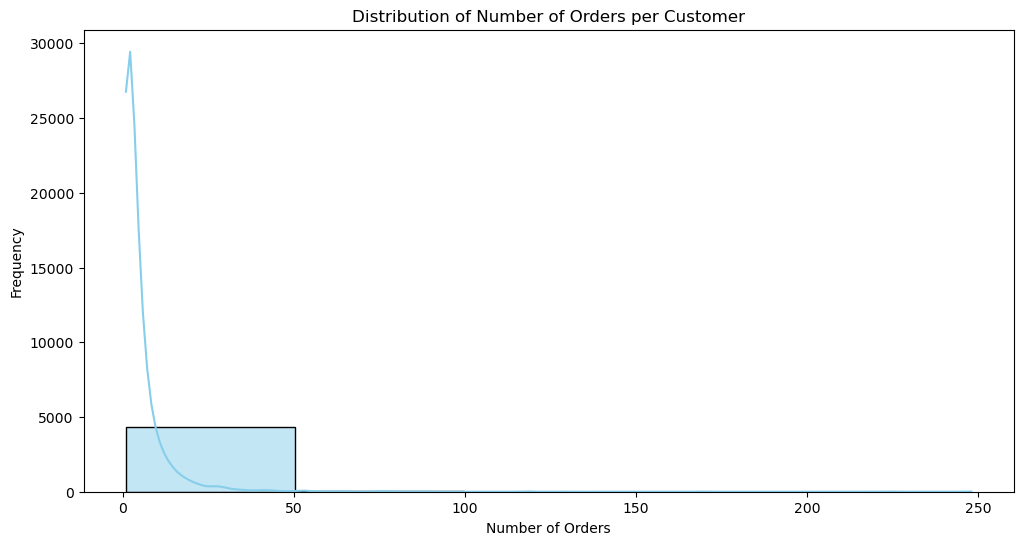

In [160]:
# Distribution of number of orders per customer
orders_per_customer = data.groupby('CustomerID')['InvoiceNo'].nunique()

plt.figure(figsize=(12, 6))
sns.histplot(orders_per_customer, bins=5, kde=True, color='skyblue')
plt.title("Distribution of Number of Orders per Customer")
plt.xlabel("Number of Orders")
plt.ylabel("Frequency")
plt.show()

Top 5 Customers and Order Count:
CustomerID
14911.0    248
12748.0    224
17841.0    169
14606.0    128
13089.0    118
Name: InvoiceNo, dtype: int64


C:\Users\nirma\AppData\Local\Temp\ipykernel_34940\1260067435.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers_by_order_count.index.astype(str), y=top_customers_by_order_count.values, palette='viridis')


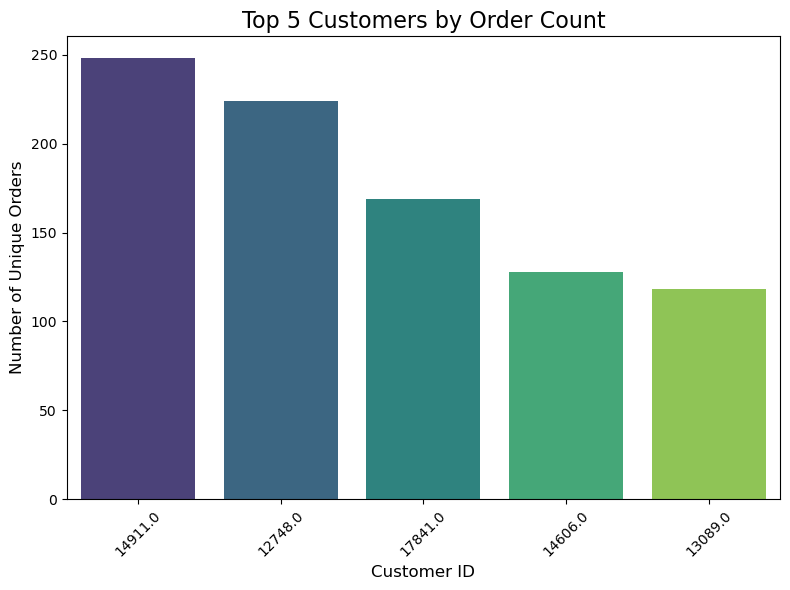

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify top 5 customers by order count
top_customers_by_order_count = data.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(5)
print("Top 5 Customers and Order Count:")
print(top_customers_by_order_count)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=top_customers_by_order_count.index.astype(str), y=top_customers_by_order_count.values, palette='viridis')
plt.title("Top 5 Customers by Order Count", fontsize=16)
plt.xlabel("Customer ID", fontsize=12)
plt.ylabel("Number of Unique Orders", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Product Analysis

In [162]:
top_products_by_frequency = data['StockCode'].value_counts().head(10)
print("Top 10 Most Frequently Purchased Products:")
print(top_products_by_frequency)


Top 10 Most Frequently Purchased Products:
StockCode
85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
20725     1359
22720     1232
POST      1196
20727     1126
22197     1118
Name: count, dtype: int64


In [163]:
average_price = data['UnitPrice'].mean()
print("Average Price of Products:", average_price)


Average Price of Products: 3.460471018536043


In [164]:
data['Revenue'] = data['Quantity'] * data['UnitPrice']
top_revenue_category = data.groupby('Description')['Revenue'].sum().idxmax()
print("Product Category Generating the Highest Revenue:", top_revenue_category)


Product Category Generating the Highest Revenue: REGENCY CAKESTAND 3 TIER


## Time Analysis

C:\Users\nirma\AppData\Local\Temp\ipykernel_34940\2705120270.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DayOfWeek', data=data, palette='viridis',


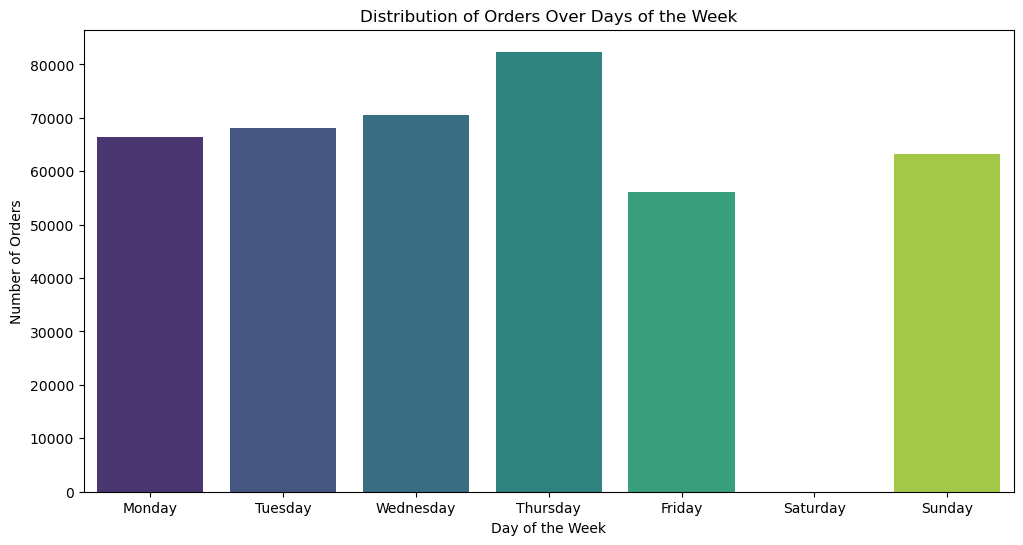

C:\Users\nirma\AppData\Local\Temp\ipykernel_34940\2705120270.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HourOfDay', data=data, palette='viridis')


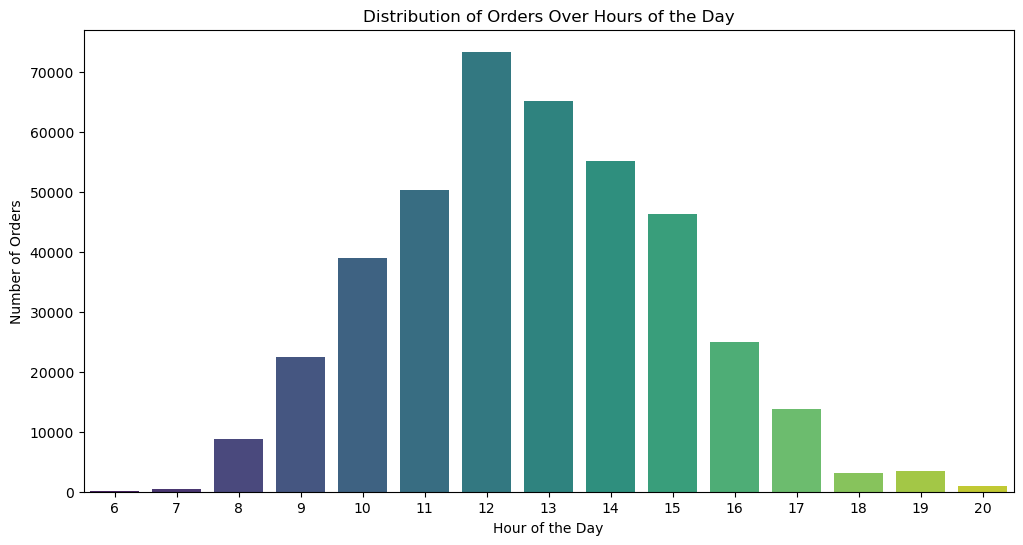

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['HourOfDay'] = data['InvoiceDate'].dt.hour

# Orders by Day of the Week
plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=data, palette='viridis', 
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Distribution of Orders Over Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Orders")
plt.show()

# Orders by Hour of the Day
plt.figure(figsize=(12, 6))
sns.countplot(x='HourOfDay', data=data, palette='viridis')
plt.title("Distribution of Orders Over Hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Orders")
plt.show()


In [166]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['OrderProcessingTime'] = data.groupby('InvoiceNo')['InvoiceDate'].transform(lambda x: x.max() - x.min())
average_processing_time = data['OrderProcessingTime'].mean()
print("Average Order Processing Time:", average_processing_time)


Average Order Processing Time: 0 days 00:00:00.238331092


C:\Users\nirma\AppData\Local\Temp\ipykernel_34940\281265125.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=data, palette='viridis')


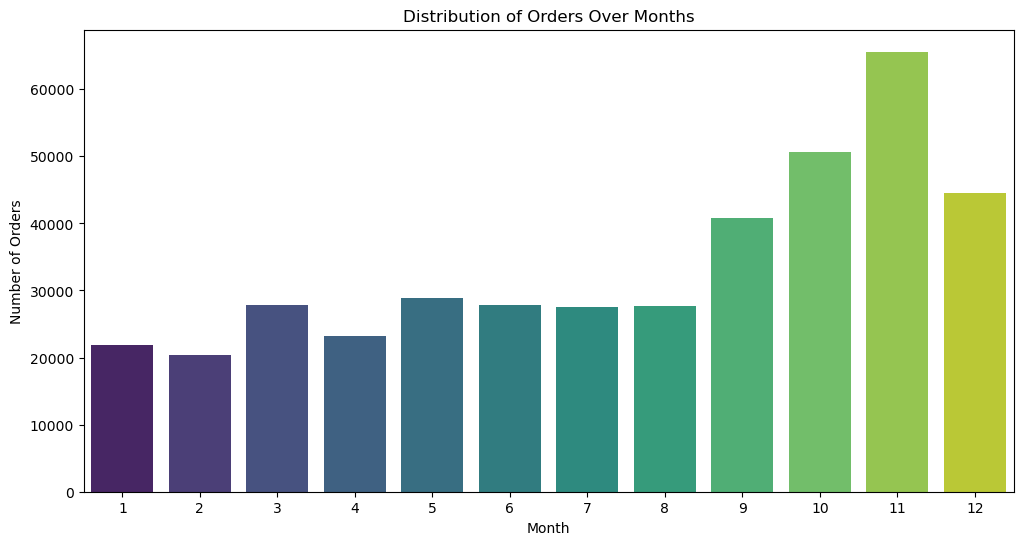

C:\Users\nirma\AppData\Local\Temp\ipykernel_34940\281265125.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Year', data=data, palette='viridis')


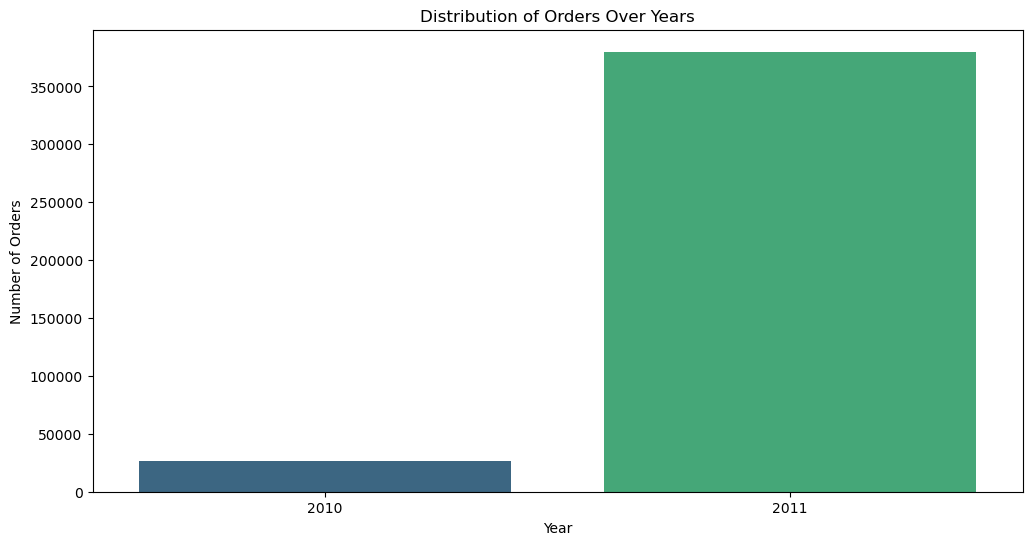

In [167]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()

# Orders by Month
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=data, palette='viridis')
plt.title("Distribution of Orders Over Months")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()

# Orders by Year
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', data=data, palette='viridis')
plt.title("Distribution of Orders Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Orders")
plt.show()


# Geographical Analysis:

In [168]:
import numpy as np

# Group data by 'Country'
grouped_data = data.groupby('Country')

# Aggregate stats
country_stats = grouped_data.agg({
    'CustomerID': 'nunique',
    'Revenue': 'mean'
}).rename(columns={'CustomerID': 'Number of Customers', 'Revenue': 'Average Order Value'})

# Correlation
correlation = np.corrcoef(country_stats['Number of Customers'], country_stats['Average Order Value'])[0, 1]
print("Correlation between Number of Customers and Average Order Value:", correlation)

# Top 5 Countries by Number of Orders
top_countries_by_orders = data['Country'].value_counts().head(5)
print("Top 5 Countries with the Highest Number of Orders:")
print(top_countries_by_orders)


Correlation between Number of Customers and Average Order Value: -0.10390345388863093
Top 5 Countries with the Highest Number of Orders:
Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: count, dtype: int64


In [169]:
import numpy as np

# Group data by country
grouped_data = data.groupby('Country')

# Aggregate statistics for each country
country_stats = grouped_data.agg({
    'CustomerID': 'nunique',
    'Revenue': 'mean'
}).rename(columns={
    'CustomerID': 'Number of Customers',
    'Revenue': 'Average Order Value'
})

# Calculate correlation between the number of customers and the average order value
correlation = np.corrcoef(country_stats['Number of Customers'], country_stats['Average Order Value'])[0, 1]
print("Correlation between Number of Customers and Average Order Value:", correlation)

# Print average order value by country
print("Average Order Value by Country:")
print(country_stats)


Correlation between Number of Customers and Average Order Value: -0.10390345388863093
Average Order Value by Country:
                      Number of Customers  Average Order Value
Country                                                       
Australia                               9           108.877895
Austria                                11            25.322494
Bahrain                                 2            32.258824
Belgium                                25            19.773301
Brazil                                  1            35.737500
Canada                                  4            24.280662
Channel Islands                         9            26.499063
Cyprus                                  8            20.813971
Czech Republic                          1            23.590667
Denmark                                 9            48.247147
EIRE                                    3            33.438239
European Community                      1            21.176230


## Customer Behaviour

In [170]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure 'InvoiceDate' is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Define a reference date (e.g., the maximum invoice date in the dataset)
reference_date = data['InvoiceDate'].max()

# Calculate Recency (days since the last purchase)
recency = (reference_date - data.groupby('CustomerID')['InvoiceDate'].max()).dt.days

# Calculate Frequency (number of unique invoices per customer)
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique()

# Calculate Monetary value (total revenue per customer)
monetary = data.groupby('CustomerID')['Revenue'].sum()

# Combine RFM data into a single DataFrame
rfm_data = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary}).reset_index()

# Scale the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

# Perform KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster Profiles
cluster_profiles = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Number of Customers'})

print("Cluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
            Recency   Frequency       Monetary  Number of Customers
Cluster                                                            
0          9.752577   28.510309   12168.264691                  194
1        247.927577    1.805942     455.110716                 1077
2          4.090909  109.909091  124312.306364                   11
3         41.780906    4.370550    1320.981506                 3090


## Profit Analysis

In [171]:
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate Revenue
data['Revenue'] = data['Quantity'] * data['UnitPrice']

# Calculate Total Profit
total_profit = data['Revenue'].sum()
print("Total Profit:", total_profit)


Total Profit: 8300065.814000001


In [172]:
# Calculate Revenue per Product
data['Revenue'] = data['Quantity'] * data['UnitPrice']

# Group by 'Description' and calculate Profit and Revenue
product_profit = data.groupby('Description')['Revenue'].sum()
product_revenue = data.groupby('Description')['Revenue'].sum()

# Calculate Profit Margin
profit_margin = (product_profit / product_revenue) * 100

# Get Top 5 Products with Highest Profit Margins
top_products = profit_margin.nlargest(5)
print("Top 5 Products with Highest Profit Margins:")
print(top_products)


Top 5 Products with Highest Profit Margins:
Description
4 PURPLE FLOCK DINNER CANDLES    100.0
50'S CHRISTMAS GIFT BAG LARGE    100.0
DOLLY GIRL BEAKER                100.0
I LOVE LONDON MINI BACKPACK      100.0
I LOVE LONDON MINI RUCKSACK      100.0
Name: Revenue, dtype: float64
